In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import pickle
import sys
import mediapipe as mp
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import LSTM
from keras.models import load_model
import tensorflow as tf
import random


classes_list = ['sad','friendly','trap','photo','map','bright','deaf','away','help','I','meet','my','name']
num_of_videos = 30
sequence_len = 20
image_height = 240
image_width = 320

In [230]:
model = load_model('models/SignLang3_model_classes=13__Loss_0.0020259341690689325__Accuracy_0.9993164539337158_bestttt.keras')

In [231]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 128)           198144    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 13)                1677      
                                                                 
Total params: 331405 (1.26 MB)
Trainable params: 331405 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [232]:
mp_holistic = mp.solutions.holistic      #Holistic model (detects)
mp_drawing = mp.solutions.drawing_utils  #drawing utilities   (draws)
mp_drawing_styles = mp.solutions.drawing_styles

holistic = mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5)


def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(101,111,10),thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(101,111,10),thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(101,111,10),thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)
                             )

In [233]:
def extract_keypoints(results):
        
    if results.pose_landmarks:
        pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten()
    else:
        pose = np.zeros(132)

    if results.left_hand_landmarks:
        lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)

    if results.right_hand_landmarks:
        rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)
            
        
    points = np.concatenate([lh,pose,rh]).astype(np.float32)
        
    return points

In [234]:
def generate_random_color():
    B = random.randint(0, 255)
    G = random.randint(0, 255)
    R = random.randint(0, 255)
    return (B, G, R)

colors = [generate_random_color() for i in range(len(classes_list))]

def prob_viz(res,frame):
    output_frame = frame.copy()
    for num,prob in enumerate(res):
        cv2.rectangle(output_frame,(0,20+num*35),(int(prob*100),50+num*35),colors[num],-1)
        cv2.putText(output_frame,classes_list[num],(0,40+num*35),cv2.FONT_HERSHEY_COMPLEX,0.8,(255,255,255),2,cv2.LINE_AA)
        
    return output_frame

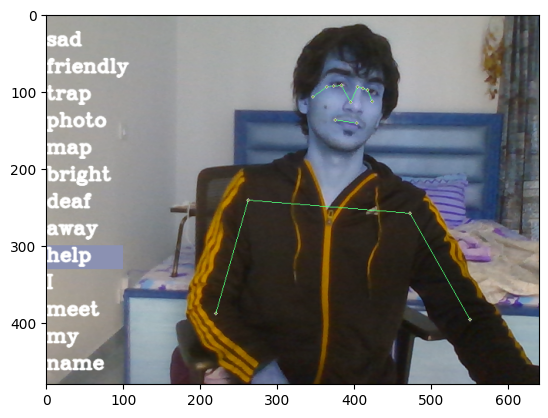

In [235]:
plt.imshow(prob_viz(res,frame))

In [238]:
cap = cv2.VideoCapture(0)

sequence = []
prob_list= []
sentence = ['Initializing....']

threshold = .9
ans = 'Initializing....'
prev = 'Initializing....'
count =0 
while(cap.isOpened()):
    
    ret,frame = cap.read()
    
    if ret == True:
        
        frame_rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        
        if results.left_hand_landmarks or results.right_hand_landmarks:
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)

            if len(sequence) >sequence_len:
                sequence = sequence[1:]

            if len(sequence) == sequence_len:
                res = model.predict(np.expand_dims(sequence,axis=0))[0]
                ans = classes_list[np.argmax(res)]
                print(ans)
                if ans == prev:
                    count+=1
                else:
                    prev=ans
                    count = 0
                    
                if sentence[-1] != ans and count >= 10:
                    sentence.append(ans)
                    if len(sentence) > 5:
                        sentence = sentence[1:]
                
            # cv2.putText(frame,' '.join(sentence),(100,30),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,255),2)
            
        draw_landmarks(frame,results)
        cv2.imshow('feed',prob_viz(res,frame))

        if cv2.waitKey(5) == ord('q'):
            break
    else:
        break
        
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step
bright
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 15ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 16ms/step
bright
1/1 [==============================] - 0s 17ms/step
bright
1/1 [==============================] - 0s 16ms/step
bright
1/1 [==============================] - 0s 17ms/step
bright
1/1 [==============================] - 0s 16ms/step
bright
1/1 [==============================] - 0s 17ms/step
bright
1/1 [==============================] - 0s 16ms/step
bright
1/1 [==========

In [225]:
cap.release()
cv2.destroyAllWindows()

In [239]:
cap = cv2.VideoCapture(0)

sequence = []
prob_list= []
sentence = ['Initializing....']

threshold = .9
ans = 'Initializing....'
prev = 'Initializing....'

while(cap.isOpened()):
    
    ret,frame = cap.read()
    
    if ret == True:
        
        frame_rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        
        if results.left_hand_landmarks or results.right_hand_landmarks:
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)

            if len(sequence) >sequence_len:
                sequence = sequence[1:]

            if len(sequence) == sequence_len:
                res = model.predict(np.expand_dims(sequence,axis=0))[0]
                ans = classes_list[np.argmax(res)]
                print(ans)
                if ans == prev:
                    prob_list.append(np.max(res))
                else:
                    prev=ans
                    prob_list = [np.max(res)]
                    
                if len(prob_list) >= 10:
                    average = sum(prob_list)/len(prob_list)
                    if sentence[-1] != ans  and average > threshold:
                        sentence.append(ans)
                        prob_list = []
                    if len(sentence) > 5:
                        sentence = sentence[1:]
                    if len(prob_list) > 10:
                        prob_list = prob_list[1:]

            cv2.putText(frame,' '.join(sentence),(100,30),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,255),2)
            
        draw_landmarks(frame,results)
        cv2.imshow('feed',prob_viz(res,frame))

        if cv2.waitKey(5) == ord('q'):
            break
    else:
        break
        
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 15ms/step
away
1/1 [==============================] - 0s 15ms/step
away
1/1 [==============================] - 0s 15ms/step
away
1/1 [==============================] - 0s 15ms/step
away
1/1 [==============================] - 0s 15ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 17ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==============================] - 0s 16ms/step
away
1/1 [==========================

In [3]:

model = load_model('models/SignLang3_model_classes=13__Loss_0.0020259341690689325__Accuracy_0.9993164539337158_bestttt.keras')


converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()



with open('model_mediapipe_rnn.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Vidit\AppData\Local\Temp\tmpya2wxu7h\assets


INFO:tensorflow:Assets written to: C:\Users\Vidit\AppData\Local\Temp\tmpya2wxu7h\assets
